In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
cpu_util = pd.read_csv("NAB/data/realKnownCause/cpu_utilization_asg_misconfiguration.csv", sep=",",)

In [3]:
cpu_util['timestamp'] = pd.to_datetime(cpu_util['timestamp'], format="%Y-%m-%d %H:%M:%S")

In [4]:
cpu_util.head()

,timestamp,value
0,2014-05-14 01:14:00,85.835
1,2014-05-14 01:19:00,88.167
2,2014-05-14 01:24:00,44.595
3,2014-05-14 01:29:00,56.282
4,2014-05-14 01:34:00,36.534


In [5]:
cpu_util.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18050 entries, 0 to 18049
Data columns (total 2 columns):
timestamp    18050 non-null datetime64[ns]
value        18050 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 282.2 KB


In [6]:
cpu_util['timestamp'].describe()

count                   18050
unique                  18050
top       2014-06-03 22:09:00
freq                        1
first     2014-05-14 01:14:00
last      2014-07-15 17:19:00
Name: timestamp, dtype: object

In [7]:
max(cpu_util['timestamp'])

Timestamp('2014-07-15 17:19:00')

### Anomaly label 
"realKnownCause/cpu_utilization_asg_misconfiguration.csv": [
        "2014-07-12 02:04:00",
        "2014-07-14 21:44:00"
    ],

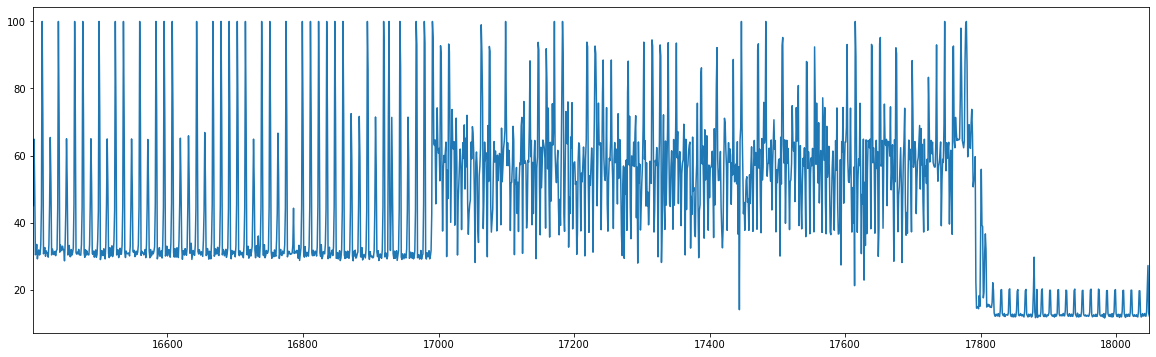

In [8]:
#Look at some anomalous data
cpu_util[cpu_util['timestamp']>'2014-07-10']['value'].plot(kind='line', figsize = (20,6))

In [9]:
cpu_util[cpu_util['timestamp']=='2014-07-12 02:04:00']

,timestamp,value
17002,2014-07-12 02:04:00,52.456


In [10]:
cpu_util[cpu_util['timestamp']=='2014-07-14 21:44:00']

,timestamp,value
17814,2014-07-14 21:44:00,14.714


In [40]:
#data preprocessing: define history window(w), threshold for anomaly, length of output(p_w)
#To determine the best combination, need to grid search
w = 45
thresh = 0.5
p_w = 1
filter_size_1 = 32
filter_size_2 = 32
kernel_size_1 = 2 # Not described in the paper
kernel_size_2 = 2 # Not described in the paper
max_pool_size_1 = 2 # Not described in the paper
max_pool_size_2 = 2 # Not described in the paper
FC_size = 50 # Not described in the paper

nFeatures = 1


In [41]:
for i in range(cpu_util.shape[0] - 45 + 1 - p_w):
    window = np.expand_dims(np.array(cpu_util['value'].iloc[i:i+w]), axis = 0)    
    label = np.expand_dims(cpu_util['value'].iloc[i+w:i+w+p_w], axis = 0)
    if i == 0:
        windows = window
        labels = label
    else:
        windows = np.append(windows, window, axis=0)
        labels = np.append(labels, label, axis = 0)

In [42]:
vector_x = np.expand_dims(windows, axis = -1) / 100
vector_x.shape

(18005, 45, 1)

In [43]:
y = np.expand_dims(cpu_util['value'].iloc[45:cpu_util.shape[0]],axis=-1) / 100
y.shape

(18005, 1)

In [44]:
from sklearn import model_selection

In [45]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(vector_x, y,test_size=0.2, shuffle=False)

In [46]:
model = tf.keras.Sequential([    
    layers.Conv1D(filter_size_1, kernel_size_1, activation='relu', input_shape=(w,nFeatures), padding='valid'),
    layers.MaxPooling1D(max_pool_size_1, strides=1, padding='same'),
    layers.Conv1D(filter_size_2, kernel_size_2, activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dense(FC_size),
    layers.Dense(p_w)
])

In [47]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
            metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 44, 32)            96        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 44, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 44, 32)            2080      
_________________________________________________________________
flatten_2 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                70450     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 72,677
Trainable params: 72,677
Non-trainable params: 0
__________________________________________________

In [49]:
model.fit(x_train, y_train, epochs = 10)

Train on 14404 samples
Epoch 1/10
14404/14404 [==============================] - 3s 193us/sample - loss: 0.0113 - accuracy: 0.0154
Epoch 2/10
14404/14404 [==============================] - 2s 167us/sample - loss: 0.0065 - accuracy: 0.0176
Epoch 3/10
14404/14404 [==============================] - 2s 167us/sample - loss: 0.0054 - accuracy: 0.0176
Epoch 4/10
14404/14404 [==============================] - 2s 163us/sample - loss: 0.0047 - accuracy: 0.0176
Epoch 5/10
14404/14404 [==============================] - 2s 164us/sample - loss: 0.0043 - accuracy: 0.0176
Epoch 6/10
14404/14404 [==============================] - 2s 165us/sample - loss: 0.0039 - accuracy: 0.0176
Epoch 7/10
14404/14404 [==============================] - 2s 164us/sample - loss: 0.0036 - accuracy: 0.0176
Epoch 8/10
14404/14404 [==============================] - 2s 165us/sample - loss: 0.0033 - accuracy: 0.0176
Epoch 9/10
14404/14404 [==============================] - 2s 162us/sample - loss: 0.0031 - accuracy: 0.0175
Epoch

In [50]:
model.evaluate(x_valid, y_valid, verbose=2)

3601/3601 - 1s - loss: 0.0117 - accuracy: 0.0444


[0.011737165611673853, 0.044432104]

In [51]:
predictions=model.predict(x_valid)

In [52]:
import matplotlib.pyplot as plt

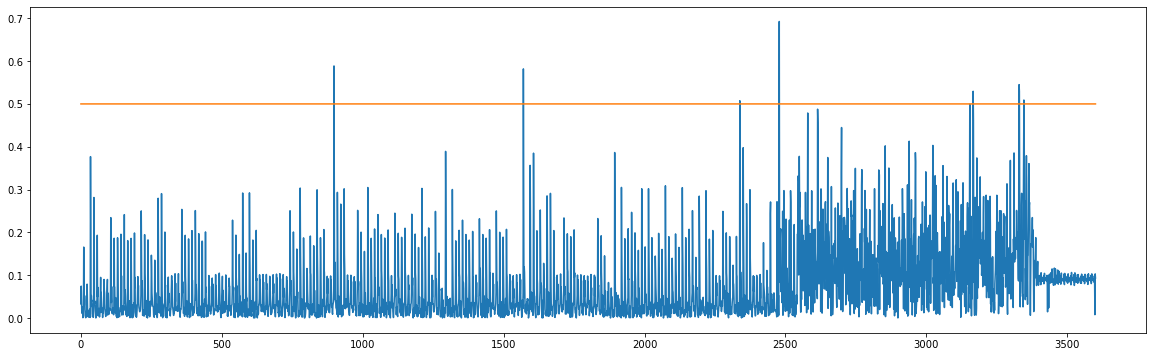

In [53]:
plt.figure(figsize=(20,6))
#plt.plot(y_valid, c = 'blue')
#plt.plot(predictions, c = 'orange')
plt.plot(((y_valid - predictions)**2)**0.5)
plt.plot(([0.5]*len(y_valid)))
plt.show()

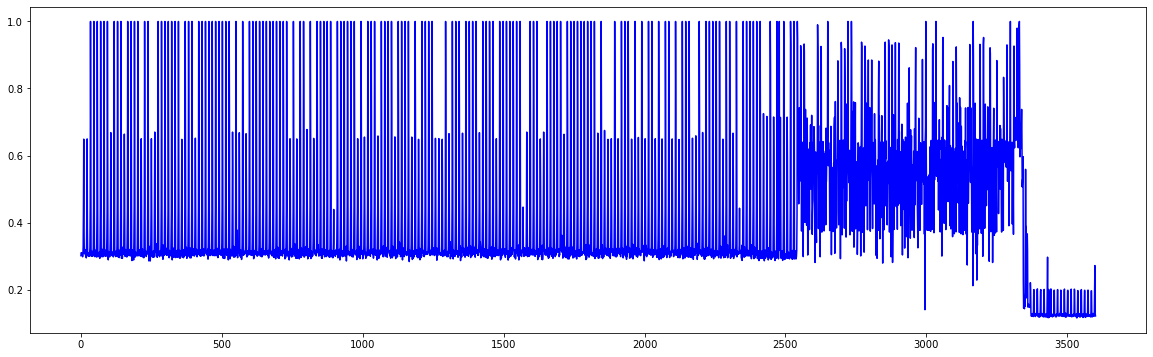

In [55]:
plt.figure(figsize=(20,6))
plt.plot(y_valid, c = 'blue')